In [1]:
#importando packages
import kagglehub
import os
import pandas as pd
import numpy as np
import warnings
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from scipy import stats

C:\Users\T-GAMER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setar display e ignorar avisos
pd.set_option('display.Max_columns', None)
pd.set_option('display.width', None)
warnings.filterwarnings('ignore')

In [3]:
## COLETA DE DADOS

In [4]:
# carregar o dataset
adult=fetch_ucirepo(id=2)
x=pd.DataFrame(adult.data.features)
y=pd.DataFrame(adult.data.targets)
df=pd.concat([x,y], axis=1)

In [5]:
## TRATAMENTO DE DADOS

In [6]:
#tratamento de valores ausentes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
df['native-country'].value_counts()

native-country
United-States                 43832
Mexico                          951
?                               583
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru         

In [8]:
# Tratando valores ausentes
df=df.replace('?', pd.NA)
for col in ['workclass', 'occupation', 'native-country']:
    df[col] = df[col].fillna(df[col].mode()[0])

In [9]:
df['native-country'].value_counts()

native-country
United-States                 44689
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador      

In [10]:
# removendo a coluna 'fnlwgt' e 'education' - fnlwgt -> peso do censo, education -> usar a education_num
df=df.drop(columns=['fnlwgt', 'education'])

In [11]:
df['income'].value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [12]:
df['income'] = df['income'].str.replace(r'\.', '', regex=True)

In [13]:
df['income']

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
48837    <=50K
48838    <=50K
48839    <=50K
48840    <=50K
48841     >50K
Name: income, Length: 48842, dtype: object

In [14]:
# codificar o income
Target_maping = {
    '<=50K': 0,
    '>50K': 1
}

df['income']=df['income'].map(Target_maping)


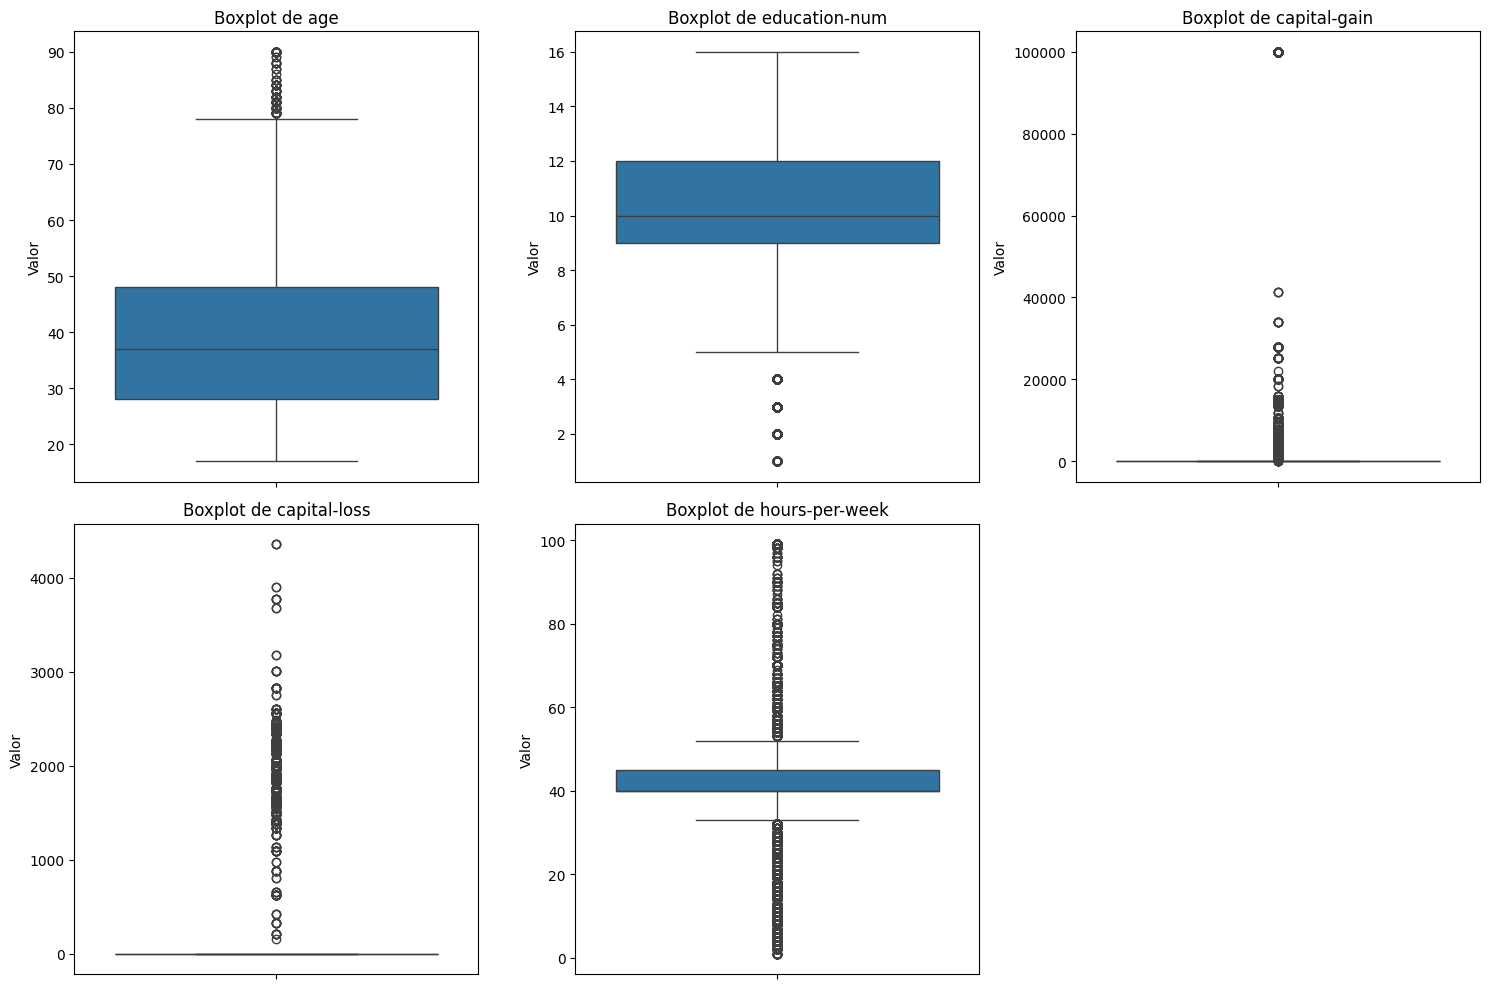

In [15]:
numeric_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot de {column}')
    plt.ylabel('Valor')

plt.tight_layout()
plt.show()

In [16]:
print(f"Linhas antes de  remover outliers: {df.shape[0]}")
df = df[(stats.zscore(df['capital-gain']) < 3) & (stats.zscore(df['capital-loss']) < 3)]
removed_rows = df.shape[0]
print(f"Linhas restantes após remover outliers: {removed_rows}")

Linhas antes de  remover outliers: 48842
Linhas restantes após remover outliers: 46295


In [17]:
## ENGENHARIA DE FEATURES
df['age_bin']=pd.cut(df['age'], bins=[17, 30, 45, 60, 90], labels=['18-30','31-45', '46-60', '+60'])
df['hours_worked']=pd.cut(df['hours-per-week'], bins=[0,35,40,100], labels=['meio periodo', 'integral', 'horas extras'])


In [18]:
# pré-processamento automático
colunas_categoricas = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'age_bin', 'hours_worked']
colunas_numericas = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [19]:
df_clean = df.dropna(subset=['income'])
features = df_clean.drop(columns="income")
target = df_clean["income"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=42
)

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), colunas_categoricas),
        ('scaler', StandardScaler(), colunas_numericas)
    ],
    remainder='drop'
)

In [21]:

print(X_train.columns)

Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'age_bin', 'hours_worked'],
      dtype='object')


In [22]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

In [23]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country', 'age_bin',
                                                   'hours_worked']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [24]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Acurácia: 0.82
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      7214
           1       0.56      0.87      0.68      2045

    accuracy                           0.82      9259
   macro avg       0.76      0.84      0.78      9259
weighted avg       0.87      0.82      0.83      9259



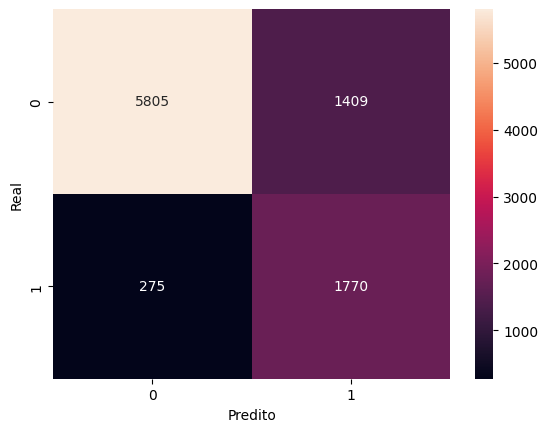

In [25]:
sns.heatmap(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito']), annot=True, fmt='d')
plt.show()

In [26]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [30]:
model_v2 = RandomForestClassifier(class_weight='balanced')
model_v2.fit(X_train_processed, y_train)
y_pred = model_v2.predict(X_test_processed)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Classification: {classification_report(y_test, y_pred)}')

Accuracy: 0.846419699751593
Classification:               precision    recall  f1-score   support

           0       0.90      0.91      0.90      7214
           1       0.66      0.63      0.64      2045

    accuracy                           0.85      9259
   macro avg       0.78      0.77      0.77      9259
weighted avg       0.84      0.85      0.85      9259



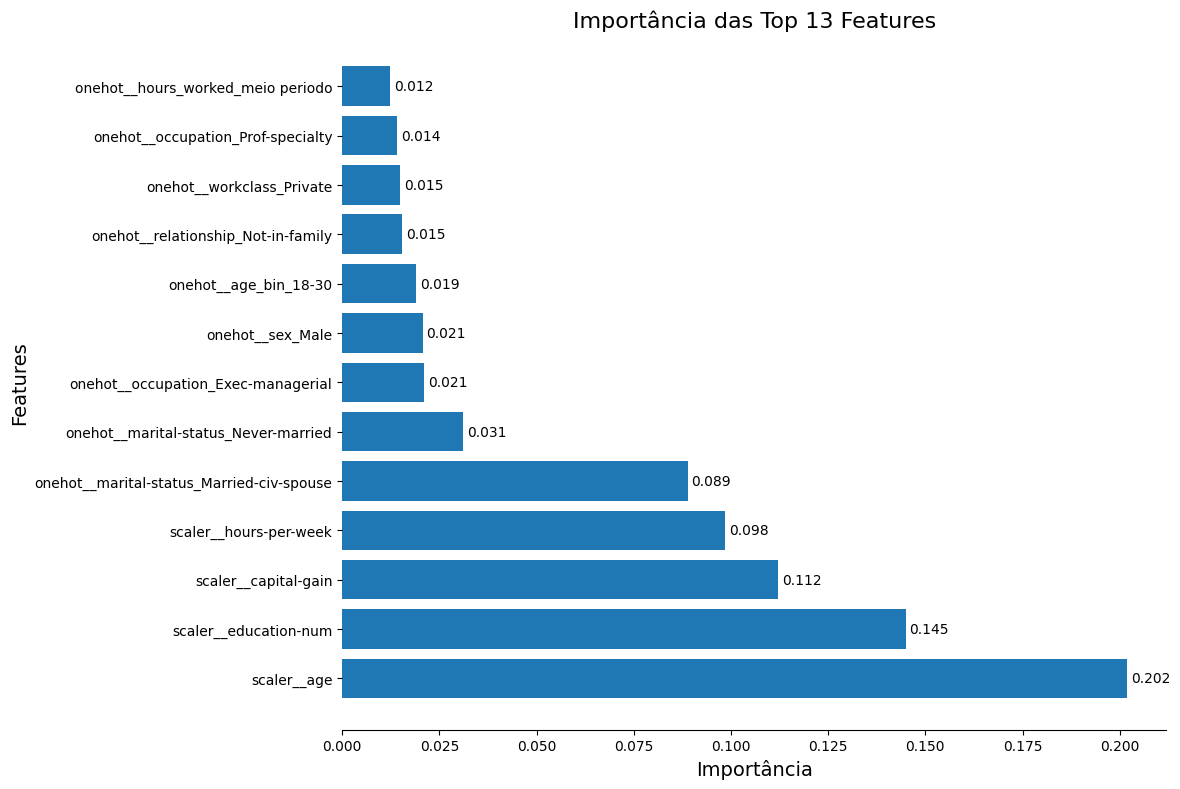

In [28]:
column_names = preprocessor.get_feature_names_out()
X_train_processed_df = pd.DataFrame.sparse.from_spmatrix(X_train_processed, columns=column_names)
importances = pd.Series(model_v2.feature_importances_, index=X_train_processed_df.columns)
sorted_importances = importances.sort_values(ascending=False)
top_13_importances = sorted_importances.head(13)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top_13_importances.index, top_13_importances.values)

for i, v in enumerate(top_13_importances.values):
    ax.text(v + 0.001, i, str(round(v, 3)), va='center', fontsize=10) 

ax.set_title('Importância das Top 13 Features', fontsize=16)
ax.set_xlabel('Importância', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.spines[['right', 'top', 'left']].set_visible(False)
plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.1)
plt.tight_layout()
plt.show()